# **Data Science for Business - Labor Market Analysis**

The aim of this project is to analyse, by means of data science techniques, the labor market for Lombardia, region of the North Italy.
In particular in this notebook we will see:
<ul>
    <li>Data Collecting - Retrive data from web sources</li>
    <li>Data Cleaning</li>
    <li>Statistics, distribution analysis and some geostatistic analysis</li>
    <li>Anticipation of the labor market by mean of time series prediction, in particular: where new job opportunitites will be created and how will be the medium salary for the economic sector</li>
    <li>Comparison between different model by mean of different metrics</li>
</ul>

Let's import all needed library

In [1]:
#Import Libraries
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
import scipy as sp
import requests
import os
from datetime import datetime

In [2]:
# Pandas: allow Pandas Dataframe to be printed withput truncation
pd.set_option('display.max_colwidth', None)

# Data Collecting - Retrive data from web sources

First of all let's retrive the main dataset selected for the analysis from the site of Regione Lombardia. 
This dataset contains all new activared labour contract in Lombardia.

You can find a backup of all the dataset used here: dslkadjklalkjadslkjdasljkdasljkadsljkdasljkadsjlk

In [3]:
path = "./datasets/"
dataset = "Rapporti_di_lavoro_attivati.csv"

if not os.path.exists(path):
    os.mkdir(path)

if not os.path.exists(path + dataset):
    r = requests.get("https://dati.lombardia.it/api/views/qbau-cyuc/rows.csv?accessType=DOWNLOAD", allow_redirects=True)
    open(path + dataset, 'wb').write(r.content)

Load CSV file into Panda DataFrame

In [4]:
df_lav_att = pd.read_csv(path + dataset)
df_lav_att

DATA GENERE  ETA  \
0        09/05/2020      F   60   
1        12/07/2019      M   43   
2        05/06/2013      F   20   
3        12/03/2010      F   28   
4        06/04/2021      F   49   
...             ...    ...  ...   
9579789  01/03/2020      M   52   
9579790  06/09/2010      M   61   
9579791  06/11/2021      M   37   
9579792  02/02/2010      M   35   
9579793  05/07/2012      F   39   

                                                                                             SETTOREECONOMICODETTAGLIO  \
0                                      Attività di famiglie e convivenze come datori di lavoro per personale domestico   
1        Gestioni di funicolari, ski-lift e seggiovie se non facenti parte dei sistemi di transito urbano o sub-urbano   
2                                                                Fabbricazione di altre apparecchiature elettriche nca   
3                                                                                                             Alberghi   
4                                                                                                   Rifugi di montagna   
...                                                                                                                ...   
9579789                                                                                   Lavori di meccanica generale   
9579790                                                                                   Lavori di meccanica generale   
9579791                                                             Fabbricazione di parti ed accessori per biciclette   
9579792                                                             Fabbricazione di parti ed accessori per biciclette   
9579793                                                            Commercio all'ingrosso di abbigliamento e accessori   

                                                                              TITOLOSTUDIO  \
0                                                                  NESSUN TITOLO DI STUDIO   
1                                                                            LICENZA MEDIA   
2                                                                            LICENZA MEDIA   
3        DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA   
4                                                                            LICENZA MEDIA   
...                                                                                    ...   
9579789                                                                      LICENZA MEDIA   
9579790                                                            NESSUN TITOLO DI STUDIO   
9579791                                                            NESSUN TITOLO DI STUDIO   
9579792                                                                      LICENZA MEDIA   
9579793                                                                      LICENZA MEDIA   

                                                                     CONTRATTO  \
0                                                             LAVORO DOMESTICO   
1                                                   LAVORO A TEMPO DETERMINATO   
2                    APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO DI MESTIERE   
3                                     LAVORO INTERMITTENTE A TEMPO DETERMINATO   
4                                                         LAVORO INTERMITTENTE   
...                                                                        ...   
9579789                                             LAVORO A TEMPO DETERMINATO   
9579790                                           LAVORO A TEMPO INDETERMINATO   
9579791                                             LAVORO A TEMPO DETERMINATO   
9579792  LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIONE) A TEMPO DETERMINATO   
9579793  LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIONE) A TEMPO DETERMINATO   

        MODALIT

Now let's download two other dataset:
<ul>
    <li><code>6f0f7122-3312-47ac-a292-7a647986387e.csv</code> usefull to group some economic sector by ATECO code from the previous dataset, we will discuss later on <a href="#Data Cleaning"></a></li>
    <li><code>DCSC_RETRATECO1_01072022002223923.csv</code> used to infer the mean salary for each ATECO code, the dataset contain historical data needed in order to try predicting the salary for the up comming future</li>
</ul>

In [7]:
dataset = "6f0f7122-3312-47ac-a292-7a647986387e.csv"
if not os.path.exists(path + dataset):
    r = requests.get("https://indicepa.gov.it/ipa-dati/datastore/dump/6f0f7122-3312-47ac-a292-7a647986387e?bom=True", allow_redirects=True)
    open(path + dataset, 'wb').write(r.content)

df_ateco = pd.read_csv(path + dataset)
df_ateco

_id Codice_ateco  \
0        1           01   
1        2         01.1   
2        3        01.11   
3        4      01.11.1   
4        5     01.11.10   
...    ...          ...   
3110  3111     98.10.00   
3111  3112         98.2   
3112  3113        98.20   
3113  3114      98.20.0   
3114  3115     98.20.00   

                                                                                       Descrizione_ateco  
0                 01 - COLTIVAZIONI AGRICOLE E PRODUZIONE DI PRODOTTI ANIMALI, CACCIA E SERVIZI CONNESSI  
1                                                 01.1 - COLTIVAZIONE DI COLTURE AGRICOLE NON PERMANENTI  
2                    01.11 - Coltivazione di cereali (escluso il riso), legumi da granella e semi oleosi  
3                                                    01.11.1 - Coltivazione di cereali (escluso il riso)  
4                                                   01.11.10 - Coltivazione di cereali (escluso il riso)  
...                                                                                                  ...  
3110     98.10.00 - Produzione di beni indifferenziati per uso proprio da parte di famiglie e convivenze  
3111      98.2 - PRODUZIONE DI SERVIZI INDIFFERENZIATI PER USO PROPRIO DA PARTE DI FAMIGLIE E CONVIVENZE  
3112     98.20 - Produzione di servizi indifferenziati per uso proprio da parte di famiglie e convivenze  
3113   98.20.0 - Produzione di servizi indifferenziati per uso proprio da parte di famiglie e convivenze  
3114  98.20.00 - Produzione di servizi indifferenziati per uso proprio da parte di famiglie e convivenze  

[3115 rows x 3 columns]

In [9]:
dataset = "Rapporti_di_lavoro_cessati.csv"
if not os.path.exists(path + dataset):
    r = requests.get("https://www.dati.lombardia.it/api/views/nwz3-p6vm/rows.csv?accessType=DOWNLOAD"", allow_redirects=True")
    open(path + dataset, 'wb').write(r.content)

df_lav_ces = pd.read_csv(path + dataset, low_memory=False)
df_lav_ces

DATA GENERE  ETA  \
0        02/04/2019      M   20   
1        08/06/2018      F   28   
2        02/02/2016      F   20   
3        12/01/2015      M   59   
4        09/08/2017      M   61   
...             ...    ...  ...   
3741389  05/11/2018      M   19   
3741390  09/04/2017      M   67   
3741391  08/05/2015      M   59   
3741392  10/10/2016      M   26   
3741393  09/10/2018      M   45   

                                                                                             SETTOREECONOMICODETTAGLIO  \
0                                                                                         Lavori di meccanica generale   
1                                                                Fabbricazione di altre apparecchiature elettriche nca   
2                                                                Fabbricazione di altre apparecchiature elettriche nca   
3        Gestioni di funicolari, ski-lift e seggiovie se non facenti parte dei sistemi di transito urbano o sub-urbano   
4        Gestioni di funicolari, ski-lift e seggiovie se non facenti parte dei sistemi di transito urbano o sub-urbano   
...                                                                                                                ...   
3741389                                      Fabbricazione di altri elementi in legno e di falegnameria per l'edilizia   
3741390                  Altra istruzione secondaria di secondo grado di formazione tecnica, professionale e artistica   
3741391                                                         Costruzione di edifici residenziali e non residenziali   
3741392                                                 Installazione di altre macchine ed apparecchiature industriali   
3741393                                          Fabbricazione di strutture metalliche e parti assemblate di strutture   

                                                                                                                    TITOLOSTUDIO  \
0                                              DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA   
1                                              DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA   
2                                              DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA   
3                                                                                                                  LICENZA MEDIA   
4                                                                                                                  LICENZA MEDIA   
...                                                                                                                          ...   
3741389  TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()   
3741390                                                                                     LAUREA - Vecchio o nuovo ordinamento   
3741391                                                                                                  NESSUN TITOLO DI STUDIO   
3741392                                        DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA   
3741393                                                                                                            LICENZA MEDIA   

                                                         CONTRATTO  \
0        APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO DI MESTIERE   
1        APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO DI MESTIERE   
2        APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO DI MESTIERE   
3                                       LAVORO A TEMPO DETERMINATO   
4                                       LAVORO A TEMPO DETERMINATO   
...                                                            ...   
3741389                                 LAVORO A TEMPO

# Data Cleaning - Part 1
<a id="data_cleaning_1"></a>
Let's manage null values by removing or interpolate values and remove unsuseful feature from datasets

In [10]:
# Dataset df_lav_att

# Rename some column
df_lav_att.rename(columns={"ITALIANO":"NAZIONE"}, inplace=True)
df_lav_att.rename(columns={"PROVINCIAIMPRESA":"PROVINCIA"}, inplace=True)

# Convert the "DATA" column into a datetime feature
df_lav_att['DATA'] = pd.to_datetime(df_lav_att['DATA'], format="%d/%m/%Y", errors='coerce')

In [11]:
# Dataset df_ateco

# Remove unuseful columns
df_ateco.drop("_id", axis=1, inplace=True)

In [12]:
# Dataset df_salary

# Remove unsueful columns
df_salary.drop("TIPO_DATO7", axis=1, inplace=True)
df_salary.drop("Tipologia di aggregato", axis=1, inplace=True)
df_salary.drop("CORREZ", axis=1, inplace=True)
df_salary.drop("Correzione", axis=1, inplace=True)
df_salary.drop("PROFILO_PROF", axis=1, inplace=True)
df_salary.drop("Qualifica professionale del dipendente", axis=1, inplace=True)
df_salary.drop("Flag Codes", axis=1, inplace=True)
df_salary.drop("Flags", axis=1, inplace=True)
df_salary.drop("Seleziona periodo", axis=1, inplace=True)

# Remove yearly data like '2005' keep only monthly data like '2015-01'
df_salary = df_salary.loc[(df_salary["TIME"].str.len() > 4)]

# Check "Value" if is null in some record
print(df_salary[df_salary["Value"].isna()])
print(df_salary[df_salary["Value"].isnull()])
print(df_salary[df_salary["Value"] == 0])

# Convert the "TIME" column into a datetime feature
df_salary['TIME'] = pd.to_datetime(df_salary['TIME'], format="%Y-%m", errors='coerce')

NameError: name 'df_salary' is not defined

No null value found in <code>df_salary</code> otherwise we have to interpolate value in order to infer the value of the salary in the missing period

# Data Exploration
Now we will plot some graph in order to find out some statistical caracteristic and possibly some problem to be solved before going deep in to our analysis. See <a href="#data_cleaning">Data Cleaning</a> section to figure out the correction applied.
Let's start exporing the first dataset <code>df_lav_att</code>

### Age Distribution

In [ ]:
# Prepare Data
lav_att_age = df_lav_att.groupby(['ETA'])['ETA'].count()
df_lav_att_age = lav_att_age.to_frame()
df_lav_att_age.columns.values[0] = "count"
df_lav_att_age.reset_index(inplace = True)
df_lav_att_age.columns.values[0] = "AGE"

# Bar plot - Age Distribution
fig = px.bar(df_lav_att_age, x="AGE", y="count", title="Age Distribution of Activated Contracts")
fig.show()

# Box Plot - Age Distribution
fig = px.box(df_lav_att_age, y="AGE", title="Age Distribution of Activated Contracts")
fig.show()

# Some Statistical data
df_lav_att_age.describe()


As you can see from the barplot and from the boxplot we have some outliers, probbly due to errors in the dataset. We can observe that there are contract activated to people being less than 16 years old (minimum required age to get a job) and activated contract to people being more than 70 years old, quite strage becuse of the retirement age in Italy is fixed at 67 yeras old for every economic sector

### Gender Distibution

In [ ]:
# Prepare Data
lav_att_gender = df_lav_att.groupby(['GENERE'])['GENERE'].count()
df_lav_att_gender = lav_att_gender.to_frame()
df_lav_att_gender.columns.values[0] = "count"
df_lav_att_gender.reset_index(inplace = True)
df_lav_att_gender.columns.values[0] = "GENDER"

lav_att_gender_age = df_lav_att.groupby(['GENERE', 'ETA'])['ETA'].count()
df_lav_att_gender_age = lav_att_gender_age.to_frame()
df_lav_att_gender_age.columns.values[0] = "count"
df_lav_att_gender_age.reset_index(inplace = True)
df_lav_att_gender_age.columns.values[0] = "GENDER"
df_lav_att_gender_age.columns.values[1] = "AGE"

# Bar plot - Gender Distibution
fig = px.bar(df_lav_att_gender, x="GENDER", y="count", color="GENDER", color_discrete_map={'M' : 'royalblue', 'F' : 'palevioletred'}, title="Gender Distribution of Activated Contracts")
fig.show()

# Box plot - Gender Distribution
fig = px.box(df_lav_att_gender_age, x="GENDER", y="AGE", title="Gender Distribution of Activated Contracts")
fig.show()

# Some Statistical data
df_lav_att_age.describe()


As we can see we have similar distribution between Male and Female even if activated contract to Female gender are less than Male, as said previously there are some outliers that are managed in <a href="#data_cleaning">Data Cleaning</a> section.

### Job Type Dsitribution

In [ ]:
# Prepare Data
lav_att_type = df_lav_att.groupby(['MODALITALAVORO'])['MODALITALAVORO'].count()
df_lav_att_type = lav_att_type.to_frame()
df_lav_att_type.columns.values[0] = "count"
df_lav_att_type.reset_index(inplace = True)
df_lav_att_type.columns.values[0] = "Job Type"
df_lav_att_type.sort_values(by=['count'], ascending=False, inplace=True)

# Bar plot - Gender Distibution
fig = px.bar(df_lav_att_type, x="Job Type", y="count", color="Job Type", title="Job Type Distribution of Activated Contracts")
fig.show()

As expected the most popular and activated job type is Full-Time Job (<code>TEMPO PIENO</code>) folloed by Part-Time Job (<code>TEMPO PARZIALE ORIZZONTALE</code>)

### Educational Qualification Distribution

In [ ]:
# Prepare Data
lav_att_edu = df_lav_att.groupby(['TITOLOSTUDIO'])['TITOLOSTUDIO'].count()
df_lav_att_edu = lav_att_edu.to_frame()
df_lav_att_edu.columns.values[0] = "count"
df_lav_att_edu.reset_index(inplace = True)
df_lav_att_edu.columns.values[0] = "Education Qualification"
df_lav_att_edu.sort_values(by=['count'], ascending=False, inplace=True)

# Bar plot - Education Qualification Distibution
fig = px.bar(df_lav_att_edu, x="Education Qualification", y="count", color="Education Qualification", title="Education Qualification Distribution of Activated Contracts")
fig.show()

Beacuse of too many class this is chart is quite ugly and unreadable, we can group some Education Qualification under the same category:

In [ ]:
df_lav_att_edu["Education Qualification"].replace(["TITOLO DI DOTTORE DI RICERCA", "LAUREA - Vecchio o nuovo ordinamento", "DIPLOMA UNIVERSITARIO", "TITOLO DI DOTTORE DI RICERCA", "DIPLOMA TERZIARIO EXTRA-UNIVERSITARIO", "MASTER UNIVERSITARIO DI PRIMO LIVELLO", "TITOLO DI STUDIO POST-LAUREA"], "LAUREA" , inplace=True)
df_lav_att_edu["Education Qualification"].replace(["DIPLOMA DI SPECIALIZZAZIONE", "TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()", "DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA"], "LICENZA SUPERIORE", inplace=True)
df_lav_att_edu["Education Qualification"].replace(["NESSUN TITOLO DI STUDIO"], "NESSUNO", inplace=True)
df_lav_att_edu.sort_values(by=['count'], ascending=False, inplace=True)

#  Bar plot - Education Qualification Distibution
fig = px.bar(df_lav_att_edu, x="Education Qualification", y="count", color="Education Qualification", title="Education Qualification Distribution of Activated Contracts")
fig.show()


### Nationality Distribution
In the <code>ITALIANO</code> column is recorded the nationality of the person taken into consideration. Let's see the distribution

In [ ]:
# Prepare Data
lav_att_nat = df_lav_att.groupby(['NAZIONE'])['NAZIONE'].count()
df_lav_att_nat = lav_att_nat.to_frame()
df_lav_att_nat.columns.values[0] = "count"
df_lav_att_nat.reset_index(inplace = True)
df_lav_att_nat.columns.values[0] = "Nationality"
df_lav_att_nat.sort_values(by=['count'], ascending=False, inplace=True)

# Bar plot - Nationality Distibution
fig = px.bar(df_lav_att_nat, x="Nationality", y="count", color="Nationality", title="Nationality Distribution of Activated Contracts")
fig.show()

### Economic Sector Distribution

In [ ]:
# Prepare Data
lav_att_eco = df_lav_att.groupby(['SETTOREECONOMICODETTAGLIO'])['SETTOREECONOMICODETTAGLIO'].count()
df_lav_att_eco = lav_att_eco.to_frame()
df_lav_att_eco.columns.values[0] = "count"
df_lav_att_eco.reset_index(inplace = True)
df_lav_att_eco.columns.values[0] = "Economic Sector"
df_lav_att_eco.sort_values(by=['count'], inplace=True)

# Bar plot - Economic Distibution
fig = px.bar(df_lav_att_eco, x="count", y="Economic Sector", color="count", orientation="h", title="Economic Sector Distribution of Activated Contracts")
fig.show()

This is quite unreadable because there are tto many economic sector in details, for this reason we can use the second proposed dataset in order to reduce and group the economic sector by mean of the ATECO code. So in the following code snippet we will join the main dataset with the ATECO Code dataset, the unused column in the resultant data frame will be removed after, only the <code>CodiceAtecoLiv1</code> will be kept.

In [ ]:
# Clean ATECO description dataset before joining, splitting "Descrizione_ateco" into "codice", "sub codice", "descrizione"
df_ateco[['codice', 'descrizione']] = df_ateco['Descrizione_ateco'].str.split(' - ', 1, expand=True)
df_ateco[['gruppo codice', 'sub codice']] = df_ateco['codice'].str.split('.', 1, expand=True)

# Join datasets
df_ateco.rename(columns={"descrizione": "SETTOREECONOMICODETTAGLIO"}, inplace=True)
df_lav_att = pd.merge(df_lav_att, df_ateco, on=["SETTOREECONOMICODETTAGLIO"])

# Prepare Data
lav_att_eco = df_lav_att.groupby(['gruppo codice'])['gruppo codice'].count()

df_lav_att_eco = lav_att_eco.to_frame()
df_lav_att_eco.columns.values[0] = "count"
df_lav_att_eco.reset_index(inplace = True)
df_lav_att_eco.sort_values(by=['count'], inplace=True)

df_lav_att_eco.rename(columns={"gruppo codice" : "codice"}, inplace=True)
df_lav_att_eco = pd.merge(df_lav_att_eco, df_ateco, on=["codice"])
df_lav_att_eco.rename(columns={"Descrizione_ateco": "Economic Sector"}, inplace=True)

# Bar plot - Economic Sector Distibution
fig = px.bar(df_lav_att_eco, x="count", y="Economic Sector", color="count", orientation="h", title="Economic Sector Distribution of Activated Contracts")
fig.show()

### Geographical Distribution
Eventually let's plot the distibution of the record present in the dataset according to the geographic location. To better visualize the distribution we will use a maps provided by Plotly Express Choropleth with GeoJSON containing the provinces of Italy and then we will use only the province belonging to region of Lombardia. For the GeoJSON data we will use this dataset https://github.com/openpolis/geojson-italy/blob/master/geojson/limits_IT_provinces.geojson. But first let's make an histogram to see which are the provinces involved.

In [ ]:
# Prepare Data
lav_att_prov = df_lav_att.groupby(['PROVINCIA'])['PROVINCIA'].count()
df_lav_att_prov = lav_att_prov.to_frame()
df_lav_att_prov.columns.values[0] = "count"
df_lav_att_prov.reset_index(inplace = True)
df_lav_att_prov.columns.values[0] = "PROVINCIA"
df_lav_att_prov.sort_values(by=['count'], inplace=True)

# Bar plot - Geogrphic Distibution
fig = px.bar(df_lav_att_prov, x="count", y="PROVINCIA", color="count", orientation="h", title="Geograhic Distribution of Activated Contracts")
fig.show()

In [ ]:
# In order to use GeoJSON let's replace location information on the main dataset in order to match the location in the GeoJSON file

df_lav_att_prov.replace("BERGAMO", "Bergamo", inplace=True)
df_lav_att_prov.replace("BRESCIA", "Brescia", inplace=True)
df_lav_att_prov.replace("COMO", "Como", inplace=True)
df_lav_att_prov.replace("CREMONA", "Cremona", inplace=True)
df_lav_att_prov.replace("LECCO", "Lecco", inplace=True)
df_lav_att_prov.replace("LODI", "Lodi", inplace=True)
df_lav_att_prov.replace("MANTOVA", "Mantova", inplace=True)
df_lav_att_prov.replace("MILANO", "Milano", inplace=True)
df_lav_att_prov.replace("MONZA E BRIANZA", "Monza e della Brianza", inplace=True)
df_lav_att_prov.replace("PAVIA", "Pavia", inplace=True)
df_lav_att_prov.replace("SONDRIO", "Sondrio", inplace=True)
df_lav_att_prov.replace("VARESE", "Varese", inplace=True)

In [ ]:
# Retrive GeoJSON border coordinates of Italy provinces from github
repo_url = 'https://raw.githubusercontent.com/openpolis/geojson-italy/master/geojson/limits_IT_provinces.geojson'
limits_IT_provinces = requests.get(repo_url).json()

# configure map with choropleth
fig = px.choropleth(data_frame=df_lav_att_prov, 
                    geojson=limits_IT_provinces, 
                    locations='PROVINCIA', # name of the column of df_lav_att_prov
                    featureidkey='properties.prov_name',  # path to field in GeoJSON in which 'PROVINCIA' values match with the GeoJSON data
                    color='count',
                    color_continuous_scale="oranges",
                    scope="europe",
                   )
fig.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds="locations")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

### Time Series - Activated Contracts

Let's see how activated change in the past years. As we can see from the scatter plot below we have some outliers we will remove them in the next chapter

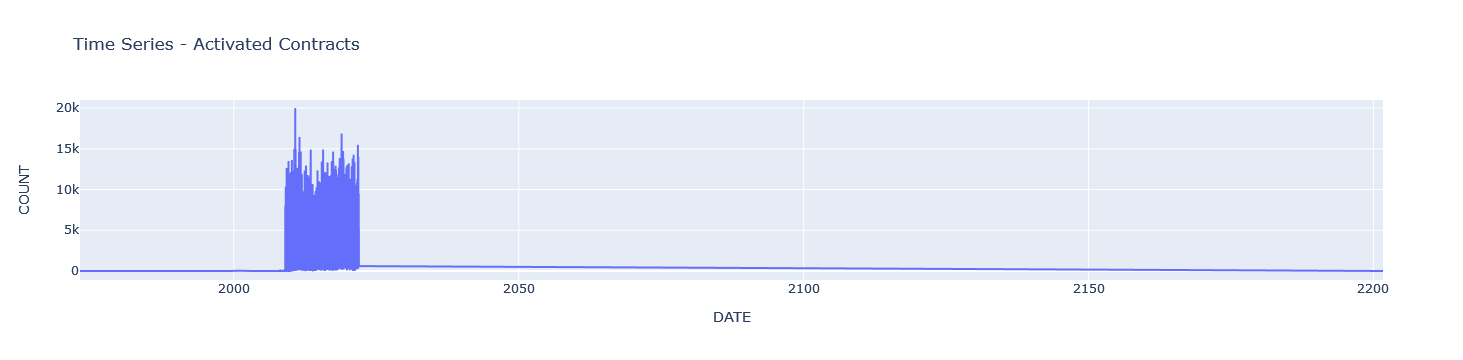

In [13]:
# Prepare Data
lav_att_time = df_lav_att.groupby(['DATA'])['DATA'].count()
df_lav_att_time = lav_att_time.to_frame()
df_lav_att_time.columns.values[0] = "COUNT"
df_lav_att_time.reset_index(inplace = True)
df_lav_att_time.columns.values[0] = "DATE"

# Scatter plot - Time Series Distribution
fig = px.line(df_lav_att_time, x='DATE', y="COUNT", title="Time Series - Activated Contracts")
fig.show()


### Time Series - Ceased Contracts

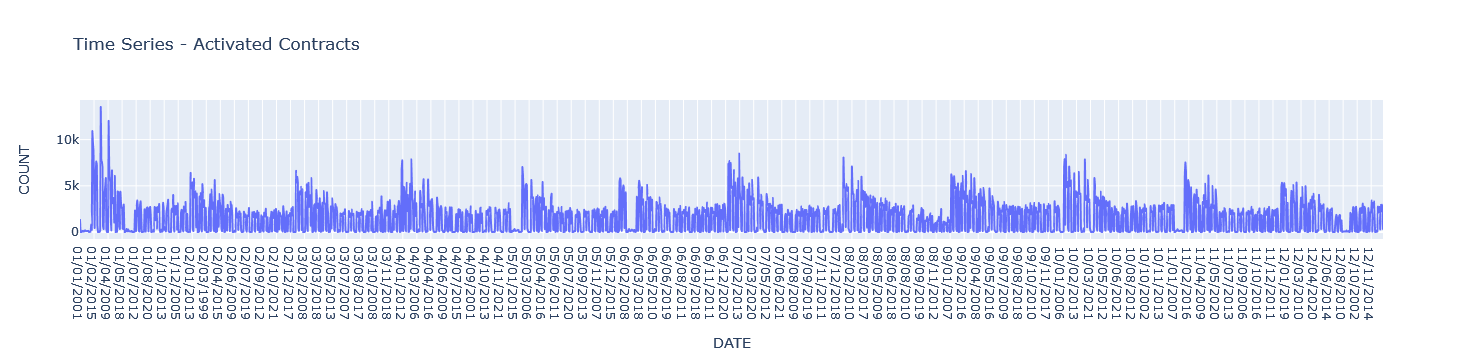

In [20]:
# Prepare Data
lav_ces_time = df_lav_ces.groupby(['DATA'])['DATA'].count()
df_lav_ces_time = lav_ces_time.to_frame()
df_lav_ces_time.columns.values[0] = "COUNT"
df_lav_ces_time.reset_index(inplace = True)
df_lav_ces_time.columns.values[0] = "DATE"

# Scatter plot - Time Series Distribution
fig = px.line(df_lav_ces_time, x='DATE', y="COUNT", title="Time Series - Activated Contracts")
fig.show()


### Data Cleaning - Part 2
In the Data exploring section we have figured out some problems due to the outliers that are present in the datasets let's remove them!

In [21]:
# Remove record with Age < 16 and Age > 67
df_lav_att = df_lav_att.loc[(df_lav_att["ETA"] >= 16) & (df_lav_att["ETA"] <= 67)]
df_lav_ces = df_lav_ces.loc[(df_lav_ces["ETA"] >= 16) & (df_lav_ces["ETA"] <= 67)]

# Remove record with Date < 01/2009 and Date > 12/2021
from_date = "2009-01-01"
to_date = "2021-12-31"
df_lav_att = df_lav_att.loc[(df_lav_att["DATA"]>=from_date) & (df_lav_att["DATA"]<=to_date)]
df_lav_ces = df_lav_ces.loc[(df_lav_ces["DATA"]>=from_date) & (df_lav_ces["DATA"]<=to_date)]

Drop the column named "ITALIANO", not useful for this type for next analysis

ATECOCODE     TIME  Value
0              A     2005   80.4
1              A  2005-01   80.4
2              A  2005-02   80.4
3              A  2005-03   80.4
4              A  2005-04   80.4
...          ...      ...    ...
499395       783  2014-08   98.2
499396       783  2014-09   98.2
499397       783  2014-10   98.2
499398       783  2014-11   98.2
499399       783  2014-12   98.2

[499400 rows x 3 columns]

Convert the colunm <code>"DATA"</code> in a date Python object

In [388]:
df_att['DATA'] = pd.to_datetime(df_att['DATA'], format="%d/%m/%Y", errors='coerce')

# remove NaT values, date that coudn't be converted from string to Python date object
df_att.dropna(axis=0, how='any', inplace=True)

df_att.groupby("DATA")["DATA"].count()

DATA
1973-01-02       1
1974-06-11       1
1976-10-01       1
1978-05-01       1
1978-07-10       1
              ... 
2021-12-06    1097
2021-12-07    6872
2021-12-08    4960
2021-12-09     601
2201-09-06       1
Name: DATA, Length: 2001, dtype: int64

As you can see there is data with date in the future, this is a mistake in the dataset, i am going to remove all tuple with date >= today

In [389]:
today = datetime.today().strftime('%Y-%m-%d')
df_att = df_att.loc[(df_att["DATA"] < today)]

<AxesSubplot:>

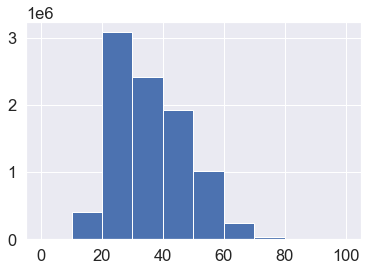

In [390]:
df_att["ETA"].hist()

As we can see there entry that presente an age < 16, is illegal to work in italy until 16 years old, moreover the retirement age in italy is about 67 years old so we can delete all entries with age < 16 and age > 67 that are probably in error in the dataset.

In [391]:
df_att.loc[(df_att["ETA"] < 16) | (df_att["ETA"] > 67)]

DATA GENERE  ETA  \
546     2019-12-07      M   95   
964     2013-08-04      M   68   
1480    2020-05-02      M   68   
1521    2019-08-08      M   70   
1574    2020-12-02      M   71   
...            ...    ...  ...   
9578758 2020-12-11      F   10   
9578816 2016-01-08      M   69   
9578891 2010-01-04      M   68   
9579417 2018-10-07      F   73   
9579538 2012-09-08      F    0   

                                 SETTOREECONOMICODETTAGLIO  \
546      Attività di organizzazioni che perseguono fini...   
964      Attività di famiglie e convivenze come datori ...   
1480     Coltivazioni agricole associate all'allevament...   
1521     Coltivazioni miste di cereali, legumi da grane...   
1574             Coltivazione di cereali (escluso il riso)   
...                                                    ...   
9578758           Programmazione e trasmissioni televisive   
9578816                Riproduzione di supporti registrati   
9578891  Costruzione di edifici residenziali e non resi...   
9579417                       Legatoria e servizi connessi   
9579538                Ideazione di campagne pubblicitarie   

                                              TITOLOSTUDIO  \
546                   LAUREA - Vecchio o nuovo ordinamento   
964                                NESSUN TITOLO DI STUDIO   
1480                                         LICENZA MEDIA   
1521                               NESSUN TITOLO DI STUDIO   
1574                                         LICENZA MEDIA   
...                                                    ...   
9578758  DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CH...   
9578816  DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CH...   
9578891                            NESSUN TITOLO DI STUDIO   
9579417  DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CH...   
9579538                        DIPLOMA DI SPECIALIZZAZIONE   

                                        CONTRATTO PROVINCIAIMPRESA  
546              LAVORO AUTONOMO NELLO SPETTACOLO            LECCO  
964                              LAVORO DOMESTICO            LECCO  
1480                   LAVORO A TEMPO DETERMINATO             LODI  
1521                   LAVORO A TEMPO DETERMINATO          MANTOVA  
1574                   LAVORO A TEMPO DETERMINATO          MANTOVA  
...                                           ...              ...  
9578758          LAVORO AUTONOMO NELLO SPETTACOLO           MILANO  
9578816          LAVORO AUTONOMO NELLO SPETTACOLO           MILANO  
9578891                LAVORO A TEMPO DETERMINATO          BRESCIA  
9579417              LAVORO A TEMPO INDETERMINATO          CREMONA  
9579538  LAVORO INTERMITTENTE A TEMPO DETERMINATO          MANTOVA  

[60159 rows x 7 columns]

In [392]:
df_att = df_att.loc[(df_att["ETA"] >= 16) & (df_att["ETA"] <= 67)]
df_ces = df_ces.loc[(df_ces["ETA"] >= 16) & (df_ces["ETA"] <= 67)]

# Data Sampling
In this analysisi only data from 2010 to 2021 is taken in account, so let's remove data outside this intervall and then take 100000 samples

In [393]:
from_date = "2010-01-01"
to_date = "2021-12-31"
df_att = df_att.loc[(df_att["DATA"]>=from_date) & (df_att["DATA"]<=to_date)]

Let's take 100000 samples from each dataset

In [394]:
df_att = df_att.sample(100000, replace=False)

# Statistics

Let's start calculating some statstics metrics for numerical columns, in this case only the age column <code>"ETA"</code>

In [395]:
print("Activated Contracts dataset")
df_att.describe()

Activated Contracts dataset


ETA
count  100000.000000
mean       35.279090
std        11.586967
min        16.000000
25%        25.000000
50%        34.000000
75%        44.000000
max        67.000000

## Frquency Analysis
**Gender distribution**

Text(0.5, 1.0, 'Gender Distribution for Active Contract')

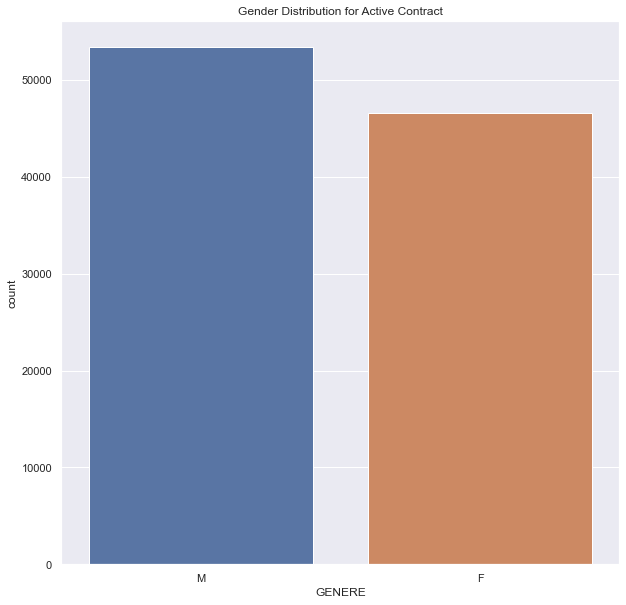

In [396]:
sns.set(rc={"figure.figsize": (10, 10)})
count_att = sns.countplot(x="GENERE", data=df_att)
count_att.set_title("Gender Distribution for Active Contract")


**Age distribution**
Now let's plot the age distribution in the 2 datasets

Text(0.5, 1.0, 'Age distribution on Activated Contracts dataset')

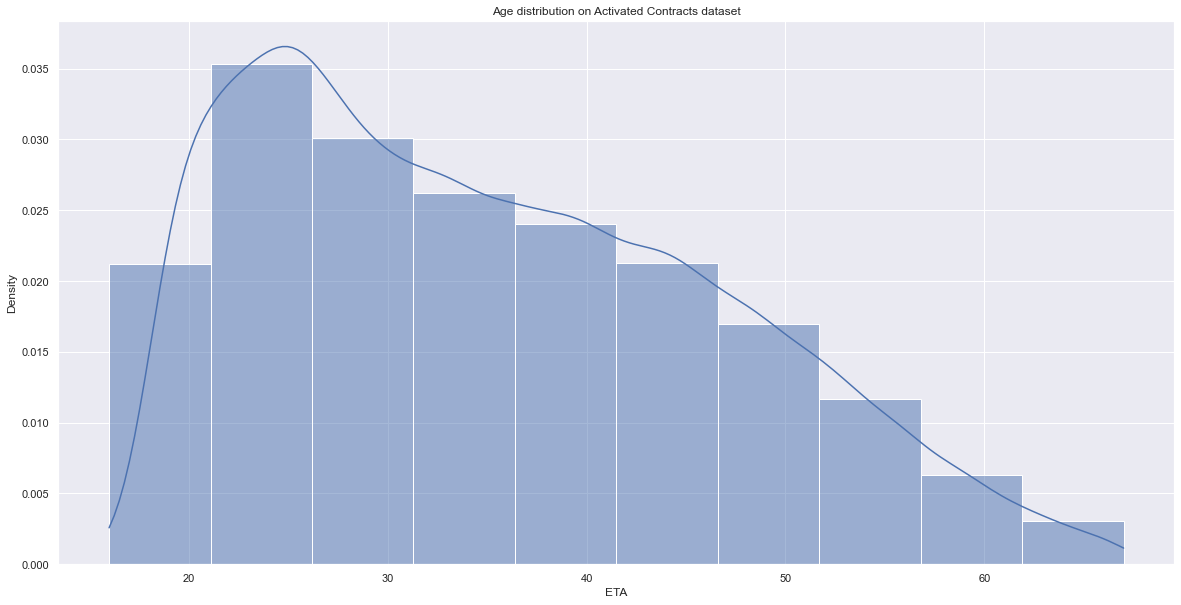

In [397]:
sns.set(rc={"figure.figsize": (20, 10)})
sns.histplot(df_att.ETA, label="AGE'", stat="density", bins=10, kde=True).set_title("Age distribution on Activated Contracts dataset")

**Top frequent activated and terminated contract**

In [398]:
freq_settore_att = df_att.groupby("SETTOREECONOMICODETTAGLIO")["SETTOREECONOMICODETTAGLIO"].count()
freq_settore_att.sort_values(ascending=False, inplace=True)
freq_settore_att = freq_settore_att.head(10)
df_top_set_att = freq_settore_att.to_frame()

df_top_set_att.rename(columns={df_top_set_att.columns[0]:"FREQUENCY"}, inplace=True)
df_top_set_att.reset_index(inplace=True)
df_top_set_att.rename(columns={df_top_set_att.columns[0]:"BUSINESS"}, inplace=True)



Top Frequency of Activated Contract per business


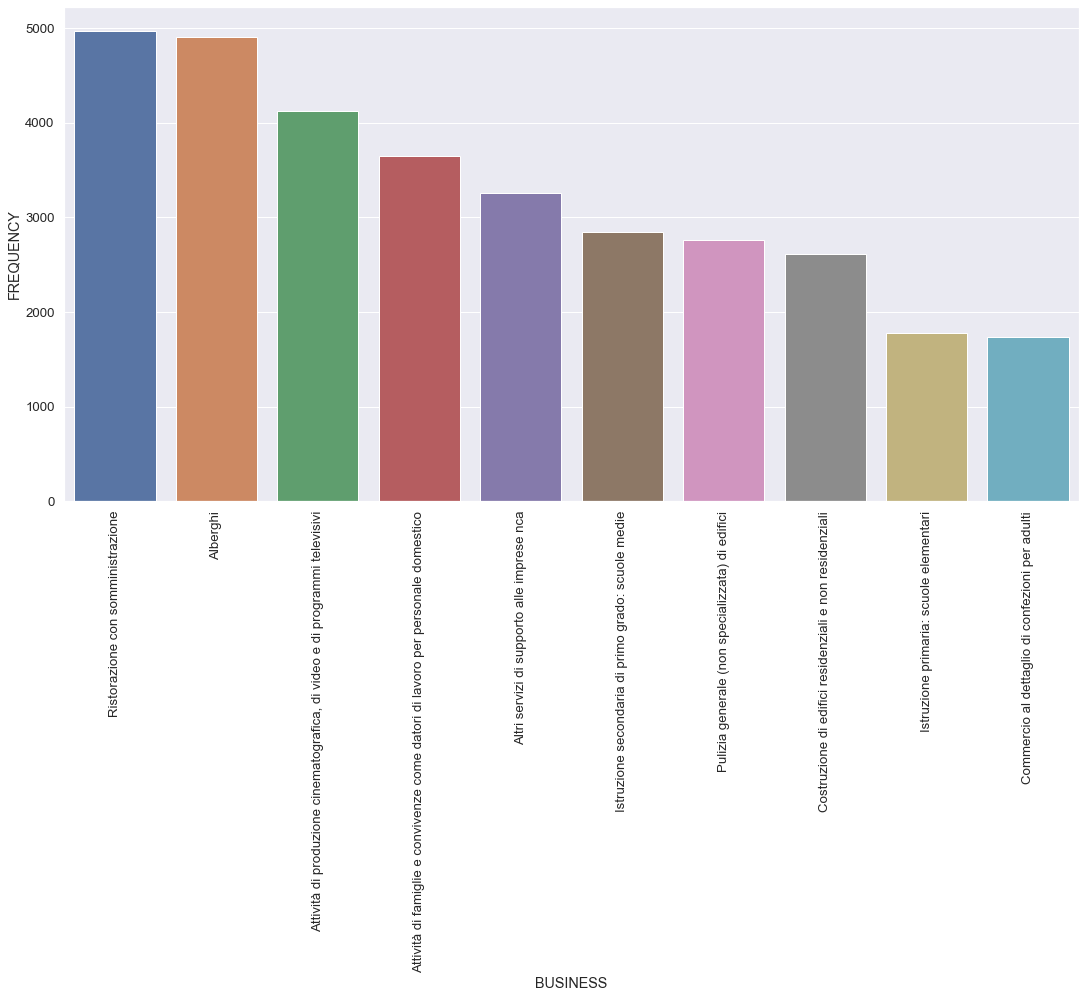

In [399]:
sns.set(rc={"figure.figsize": (40, 20)}, font_scale=1.2)
plt.subplot(2, 2, 1)
barplot = sns.barplot(x="BUSINESS", y="FREQUENCY", data=df_top_set_att)
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=90)
print("Top Frequency of Activated Contract per business")


**Geographic Distribution**

Geographic Distribution


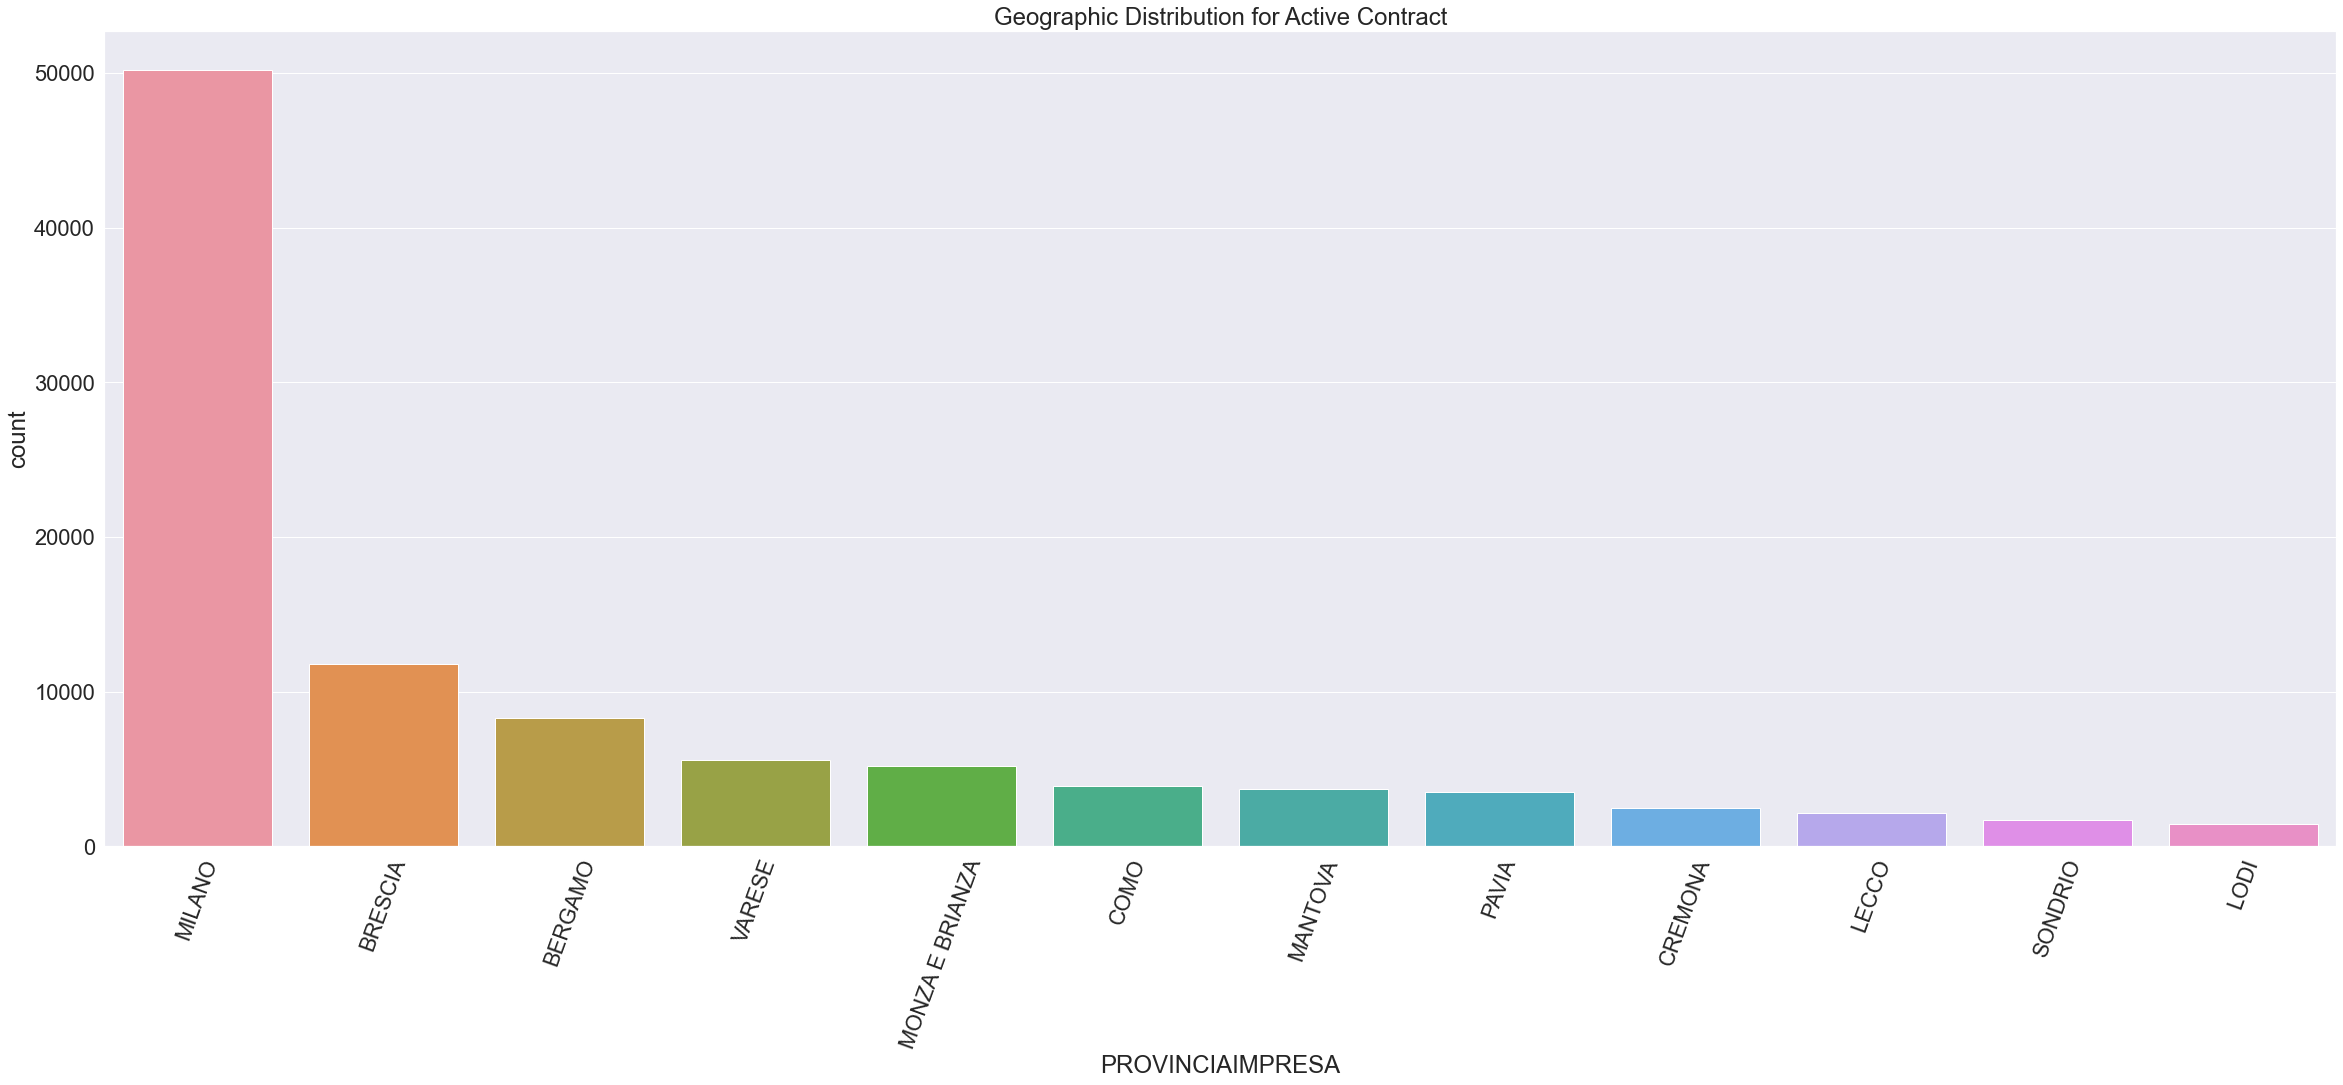

In [400]:
sns.set(rc={"figure.figsize": (40, 15)}, font_scale=2)
count_att = sns.countplot(x="PROVINCIAIMPRESA", data=df_att, order=df_att["PROVINCIAIMPRESA"].value_counts().index)
count_att.set_title("Geographic Distribution for Active Contract")
count_att.set_xticklabels(count_att.get_xticklabels(), rotation=70)

print("Geographic Distribution")

**Contract type Distribution**

Contract type Distribution


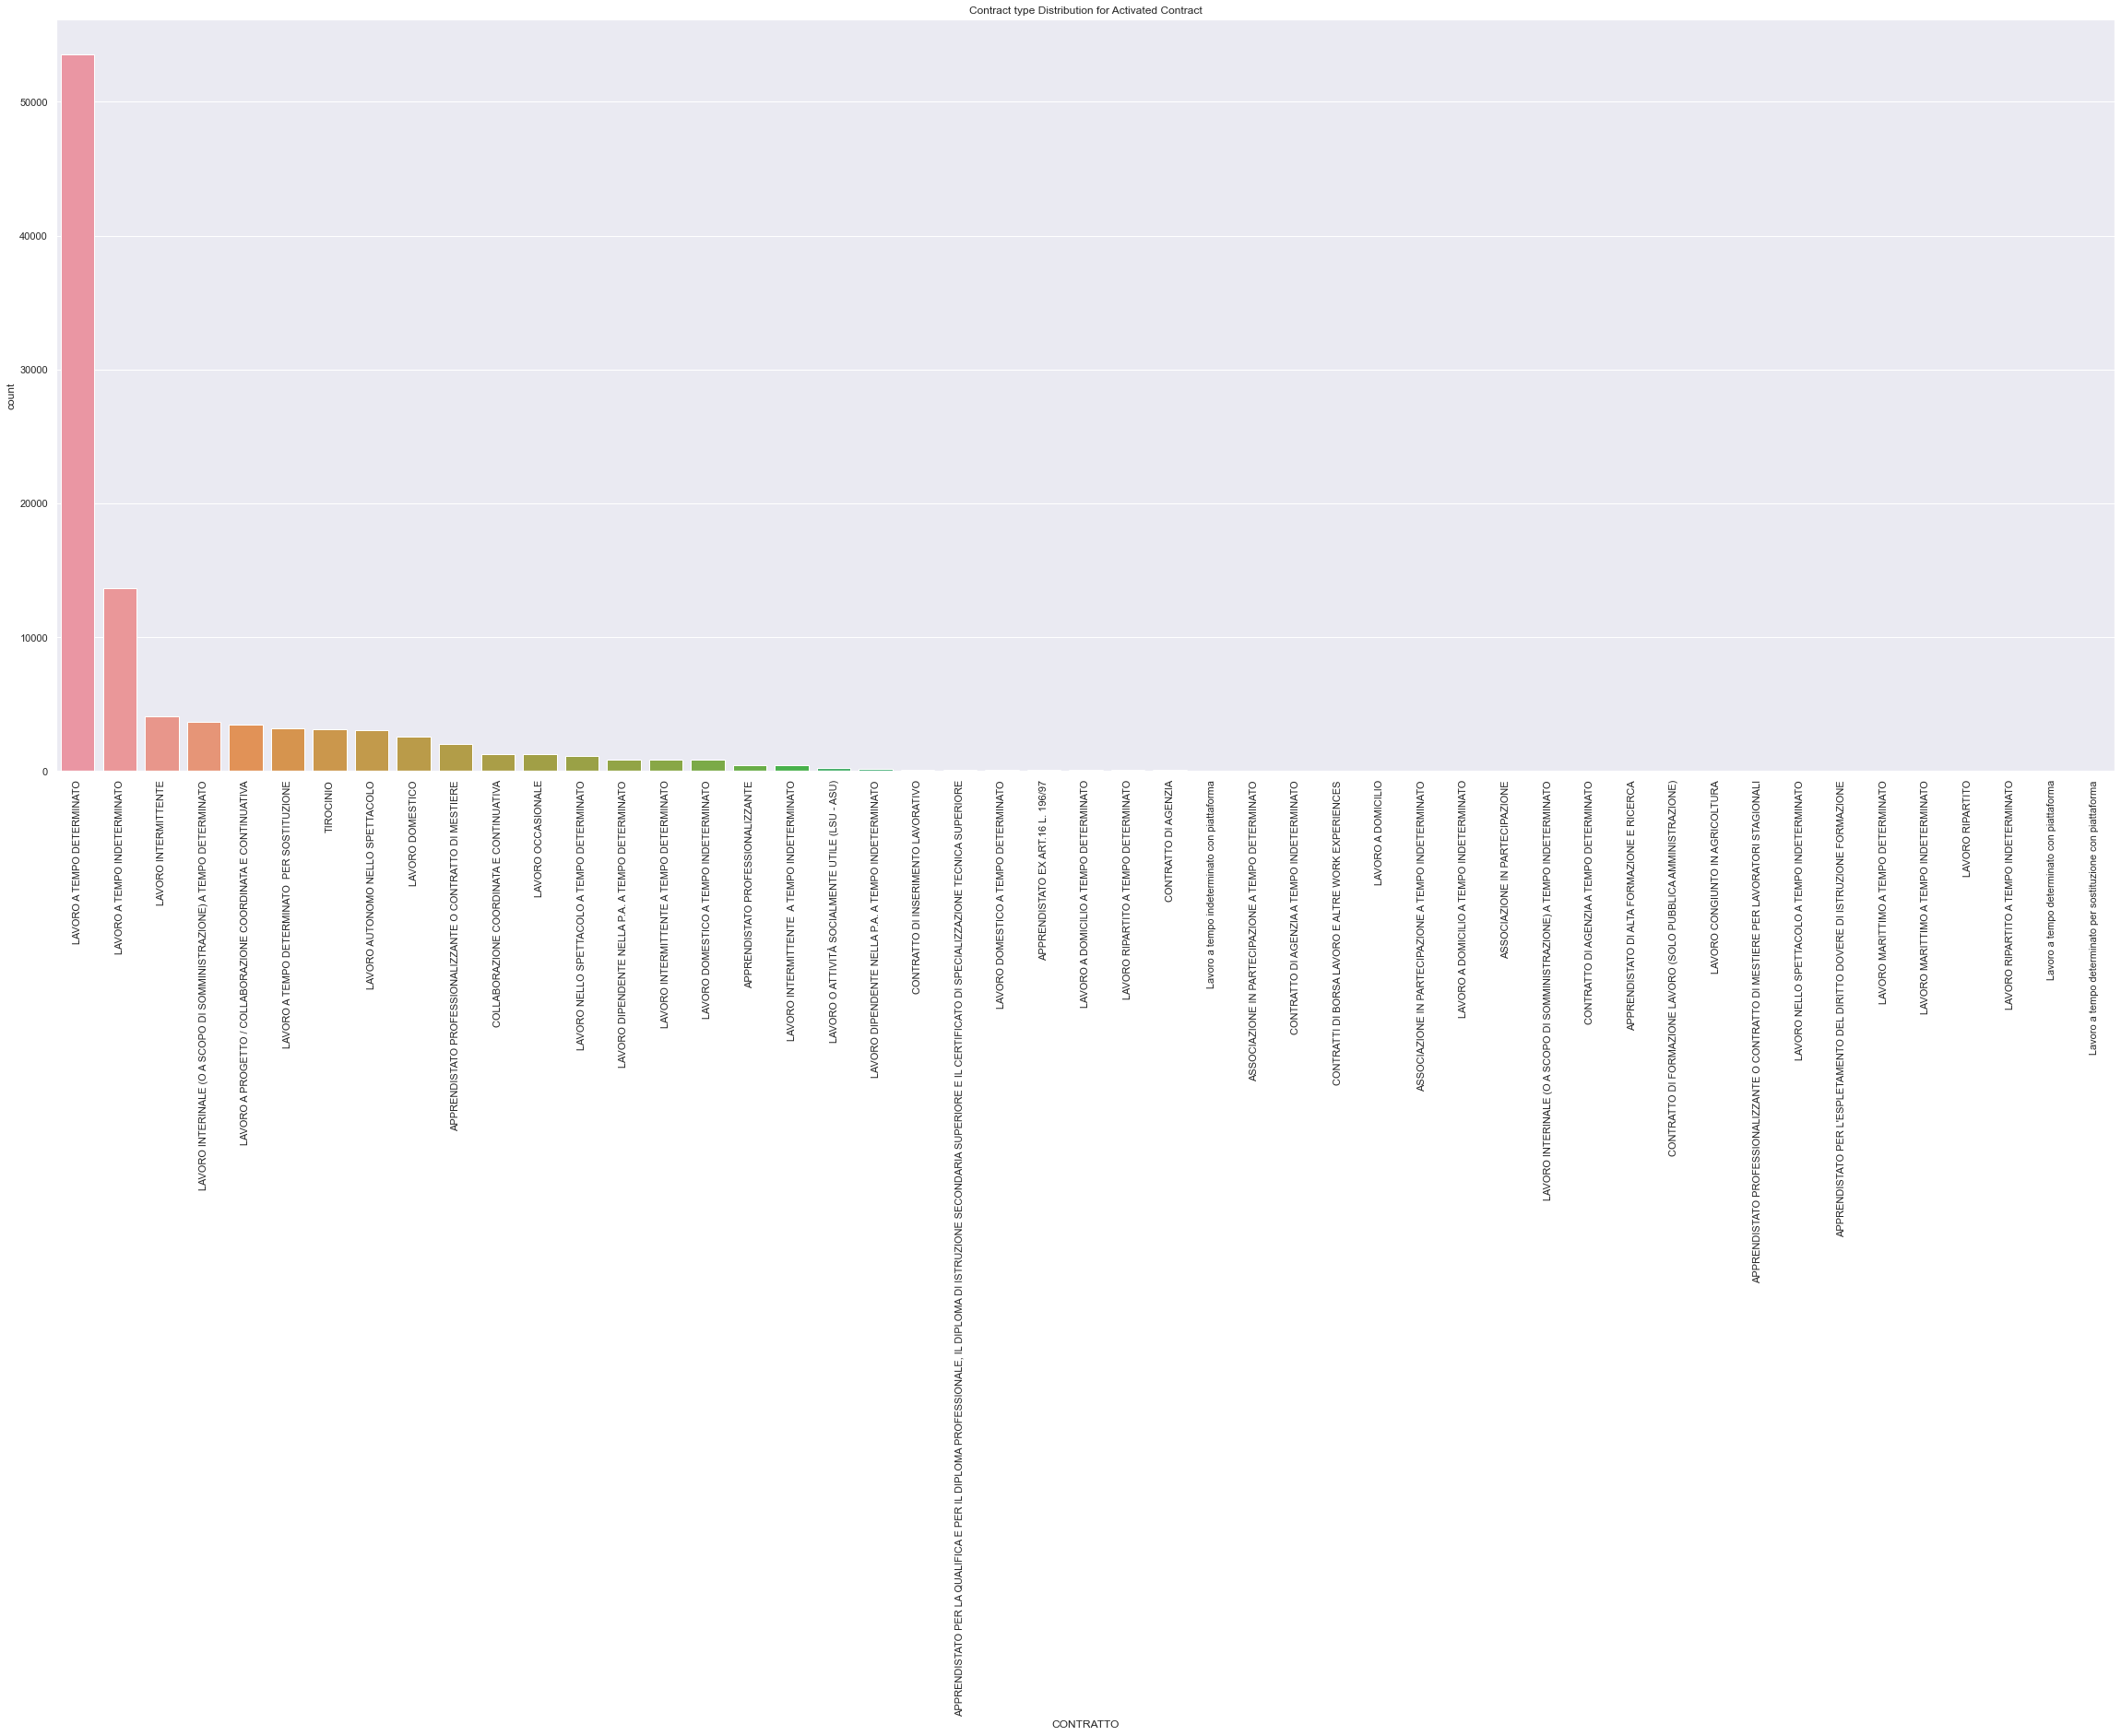

In [401]:
sns.set(rc={"figure.figsize": (40, 15)})
count_att = sns.countplot(x="CONTRATTO", data=df_att, order=df_att["CONTRATTO"].value_counts().index)
count_att.set_title("Contract type Distribution for Activated Contract")
count_att.set_xticklabels(count_att.get_xticklabels(), rotation=90)

print("Contract type Distribution")

As you can see there are too many different values let's group together similar contract type

In [402]:
def group_contract(contract):
    if "INDETERMINATO" in contract:
        return "INDETERMINATO"
    else:
        return "DETERMINATO"

    
df_att["CONTRATTO"] = df_att["CONTRATTO"].apply(group_contract)

Contract type Distribution


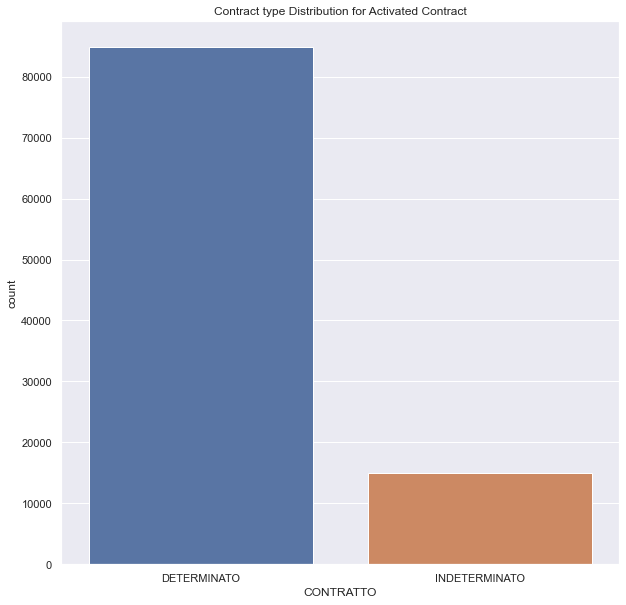

In [403]:
sns.set(rc={"figure.figsize": (10, 10)})
count_att = sns.countplot(x="CONTRATTO", data=df_att, order=df_att["CONTRATTO"].value_counts().index)
count_att.set_title("Contract type Distribution for Activated Contract")

print("Contract type Distribution")

**Education Distribution**

Education Distribution


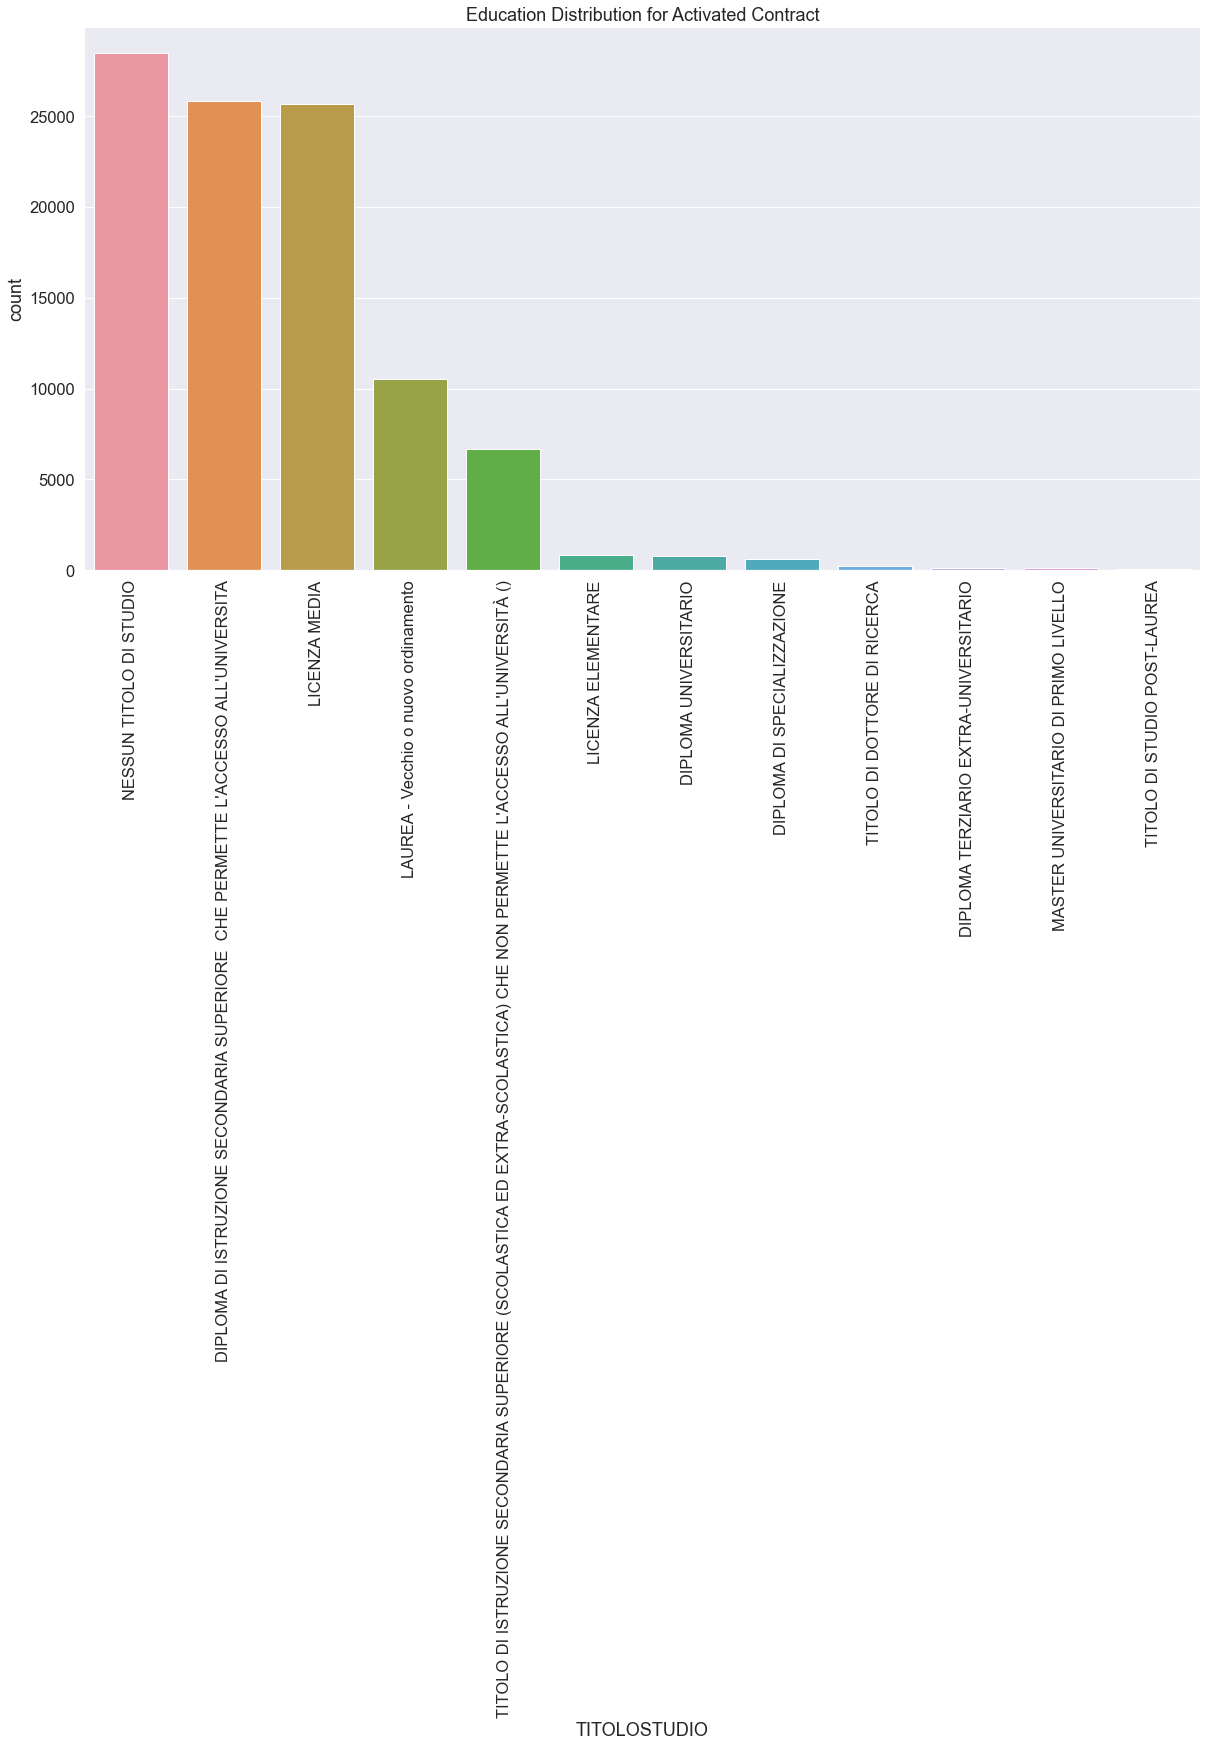

In [404]:
sns.set(rc={"figure.figsize": (20, 10)}, font_scale=1.5)
count_att = sns.countplot(x="TITOLOSTUDIO", data=df_att, order=df_att["TITOLOSTUDIO"].value_counts().index)
count_att.set_title("Education Distribution for Activated Contract")
count_att.set_xticklabels(count_att.get_xticklabels(), rotation=90)

print("Education Distribution")

## Anticipation of the labor market, where new job opportunitites will be created
In order to achieve the objective of this analysis I divide the dataset of activated contract in 4 interval of 2 years each:
<ul>
    <li>01/01/2012 - 31/12/2013</li>
    <li>01/01/2014 - 31/12/2015</li>
    <li>01/01/2016 - 31/12/2017</li>
    <li>01/01/2018 - 31/12/2019</li>
    <li>01/01/2020 - 31/12/2021</li>
</ul>

In [405]:
df_2012_2013 = df_att.loc[(df_att["DATA"]>="2012-01-01") & (df_att["DATA"]<="2013-12-31")]
df_2014_2015 = df_att.loc[(df_att["DATA"]>="2014-01-01") & (df_att["DATA"]<="2015-12-31")]
df_2016_2017 = df_att.loc[(df_att["DATA"]>="2016-01-01") & (df_att["DATA"]<="2017-12-31")]
df_2018_2019 = df_att.loc[(df_att["DATA"]>="2018-01-01") & (df_att["DATA"]<="2019-12-31")]
df_2020_2021 = df_att.loc[(df_att["DATA"]>="2020-01-01") & (df_att["DATA"]<="2021-12-31")]

As we can see from the barplots below in the 2020-2021 we have a relevant increase of contract for "Attività di famiglie e convivenze come datori di lavoro per personale domestico", probably due to the COVID-19 pandemic. For the same reason the activated contract for "Alberghi" and "Ristorazione" are decreased

Top 5 Frequency of Activated Contract per business per period


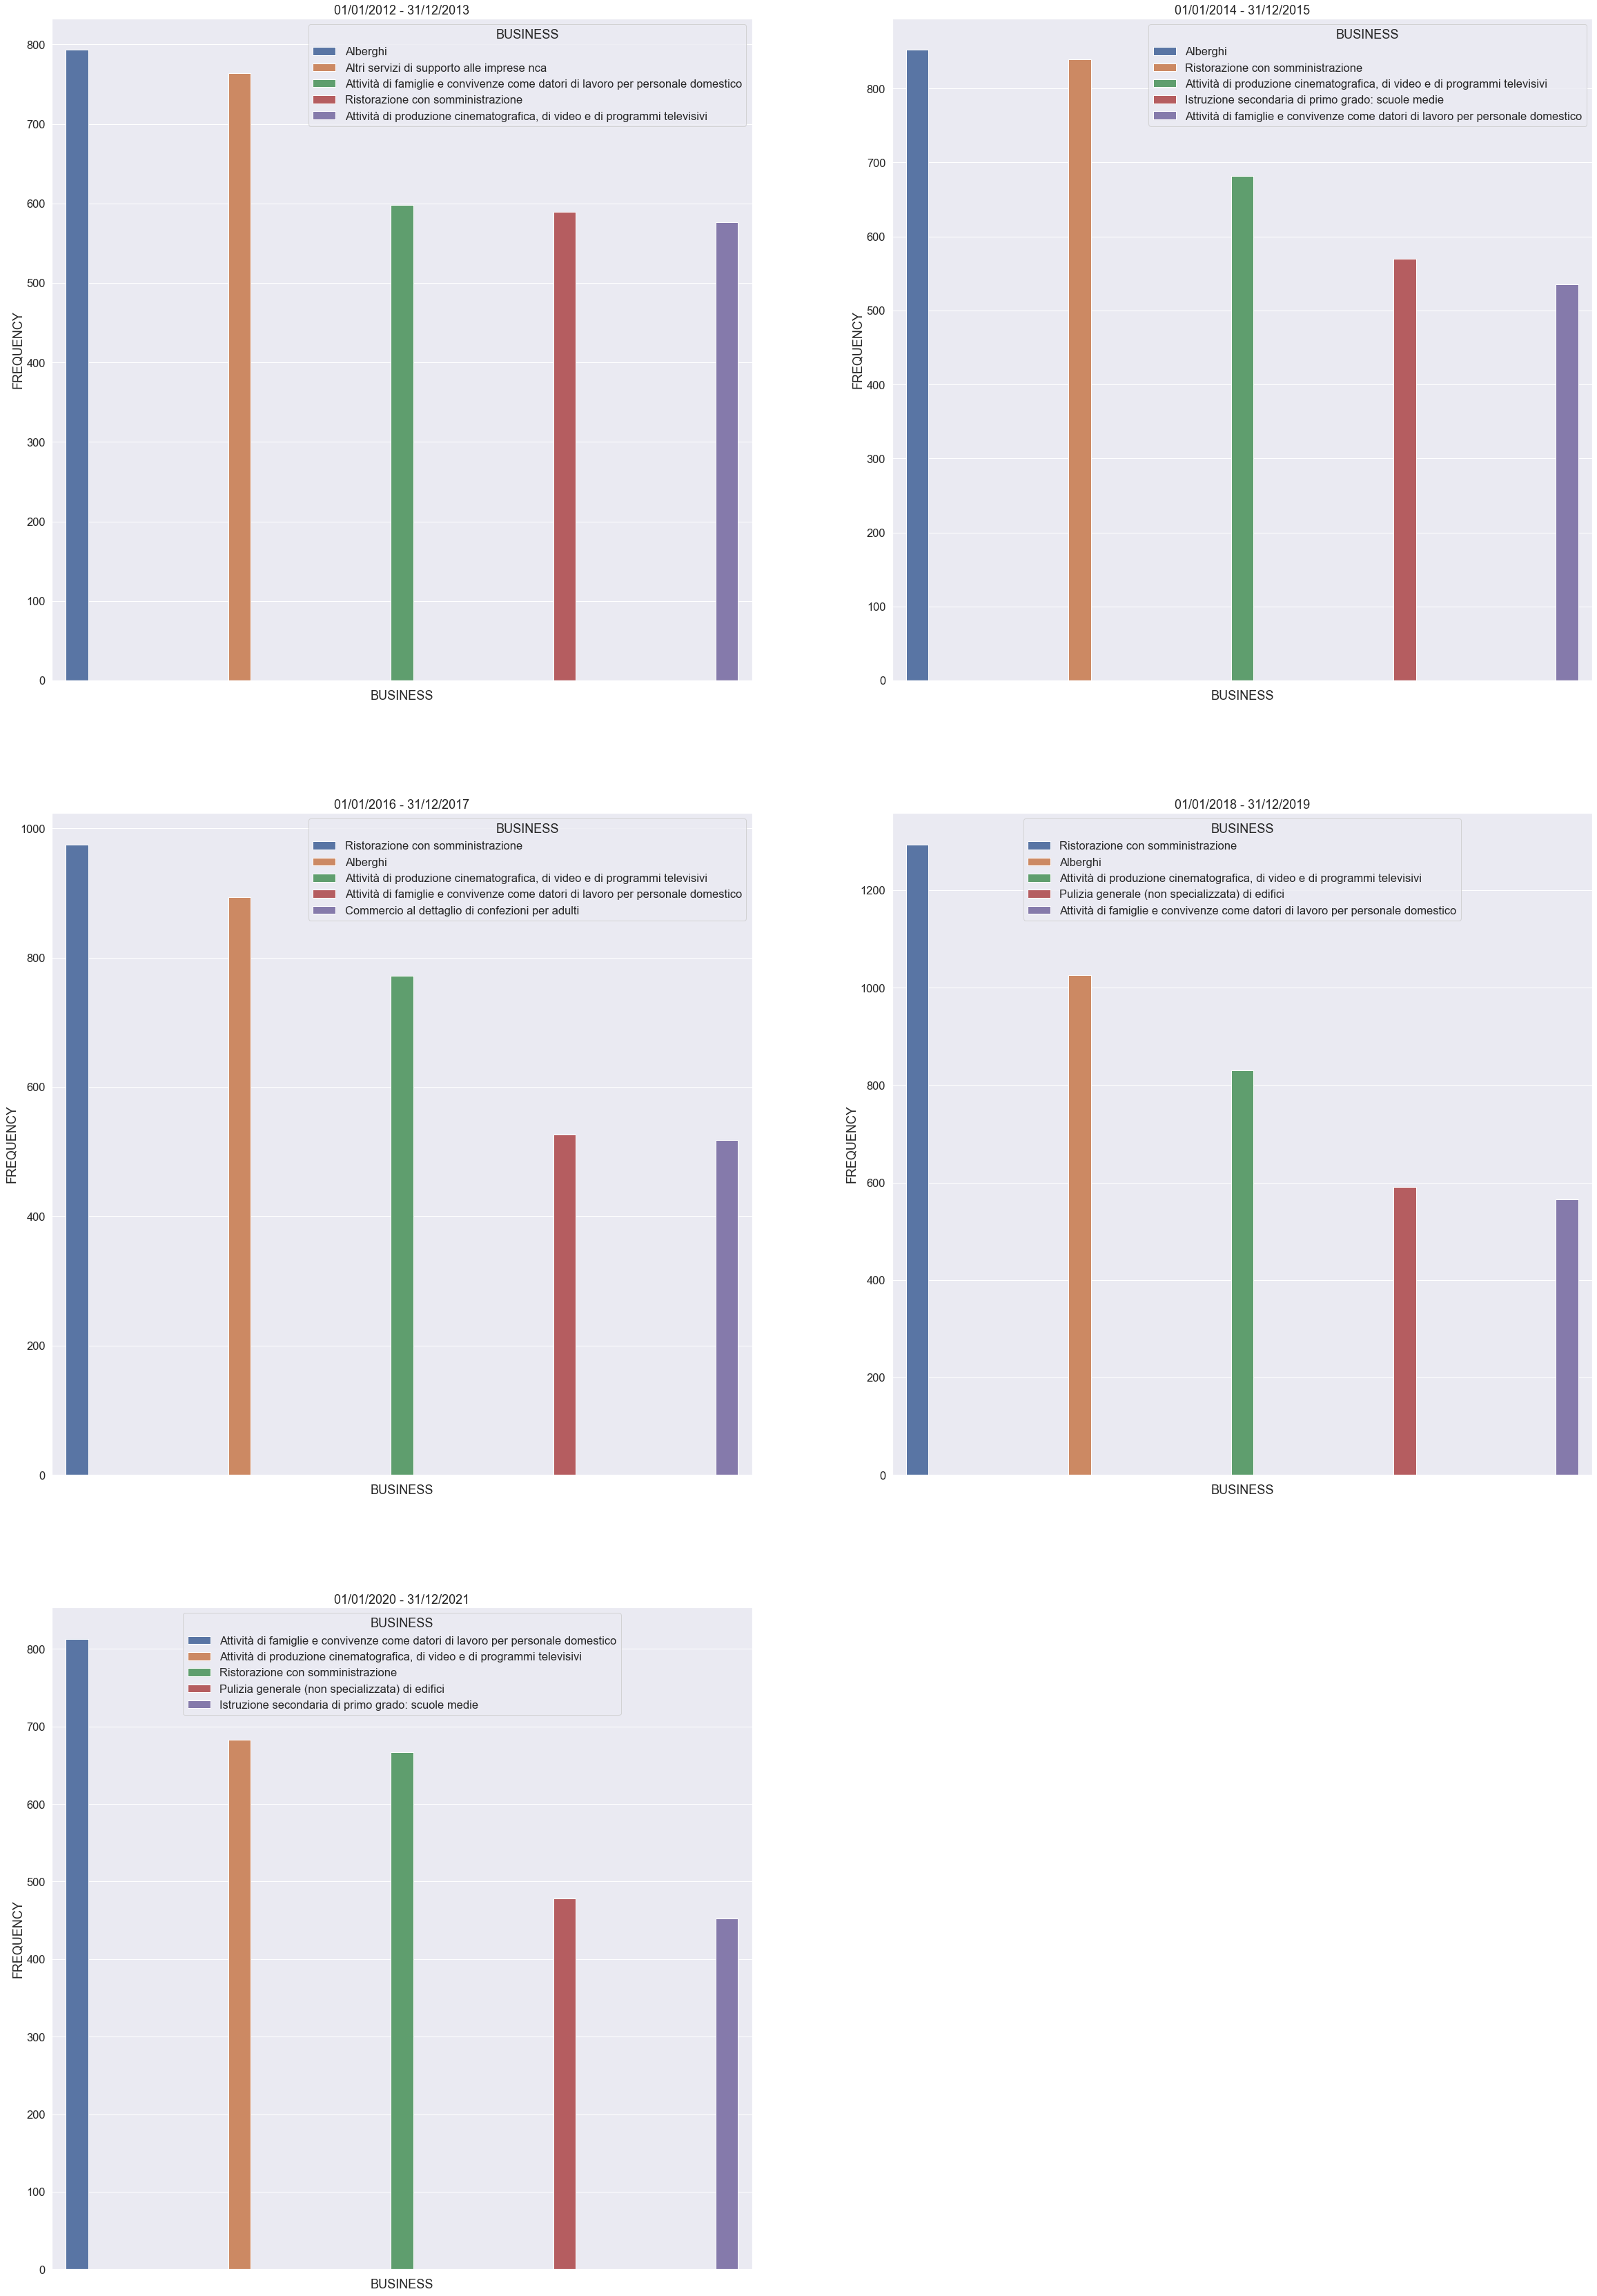

In [406]:
def barplot_interval(df, x, interval):
    freq_settore_att = df.groupby("SETTOREECONOMICODETTAGLIO")["SETTOREECONOMICODETTAGLIO"].count()
    freq_settore_att.sort_values(ascending=False, inplace=True)
    freq_settore_att = freq_settore_att.head(5)
    df_top_set_att = freq_settore_att.to_frame()
    df_top_set_att.rename(columns={df_top_set_att.columns[0]:"FREQUENCY"}, inplace=True)
    df_top_set_att.reset_index(inplace=True)
    df_top_set_att.rename(columns={df_top_set_att.columns[0]:"BUSINESS"}, inplace=True)
    
    sns.set(rc={"figure.figsize": (40, 60)}, font_scale=1.5)
    plt.subplot(3, 2, x)
    barplot = sns.barplot(x="BUSINESS", y="FREQUENCY", hue="BUSINESS", data=df_top_set_att)
    barplot.set_xticklabels([])
    barplot.set_title(interval)

barplot_interval(df_2012_2013, 1, "01/01/2012 - 31/12/2013")
barplot_interval(df_2014_2015, 2, "01/01/2014 - 31/12/2015")
barplot_interval(df_2016_2017, 3, "01/01/2016 - 31/12/2017")
barplot_interval(df_2018_2019, 4, "01/01/2018 - 31/12/2019")
barplot_interval(df_2020_2021, 5, "01/01/2020 - 31/12/2021")

print("Top 5 Frequency of Activated Contract per business per period")

## Probability to have a permanent contract in relation to the profession, the geography, the age
First of all let's cal only long term contract indentified with <code>INDETERMINATO</code> and only in the last year (2021).In order to calculate the probability we need the frequency of a long term contract **happen** divided by the **total sample** 

In [407]:
df_indet = df_att.loc[(df_att["DATA"]>="2021-01-01") & (df_att["DATA"]<="2021-12-31")]
df_indet = df_att.loc[(df_att["CONTRATTO"]=="INDETERMINATO")]

def perm_contract(df, df_indet, column):
    df_result = pd.DataFrame(data={"Value": [], "FreqInd": [], "Total": [], "Probability": []})
    values = df[column].unique()
    for v in values:
        row = {"Value": v, 
               "FreqInd": df_indet.loc[(df_indet[column]==v)].shape[0], 
               "Total": df.loc[(df[column]==v)].shape[0],
               "Probability": df_indet.loc[(df_indet[column]==v)].shape[0] / df.loc[(df[column]==v)].shape[0] * 100
              }
        df_result = df_result.append(row, ignore_index=True)
    df_result.sort_values(["Probability"], ascending=False, inplace=True)
    return df_result.head(30)


perm_contract(df_att, df_indet, "PROVINCIAIMPRESA")


Value  FreqInd    Total  Probability
9   MONZA E BRIANZA   1023.0   5169.0    19.791062
11             LODI    258.0   1457.0    17.707618
0           BERGAMO   1393.0   8332.0    16.718675
6            VARESE    904.0   5580.0    16.200717
2             PAVIA    567.0   3511.0    16.149245
8           BRESCIA   1866.0  11800.0    15.813559
4             LECCO    333.0   2176.0    15.303309
3              COMO    579.0   3923.0    14.759113
7           CREMONA    356.0   2463.0    14.453918
1            MILANO   7050.0  50205.0    14.042426
5           MANTOVA    514.0   3699.0    13.895647
10          SONDRIO    217.0   1685.0    12.878338

In [408]:
perm_contract(df_att, df_indet, "ETA")

Value  FreqInd   Total  Probability
14   36.0    505.0  2592.0    19.483025
41   38.0    478.0  2476.0    19.305331
21   33.0    524.0  2742.0    19.110139
25   40.0    464.0  2433.0    19.071106
11   35.0    485.0  2544.0    19.064465
29   32.0    530.0  2822.0    18.781006
18   47.0    353.0  1908.0    18.501048
7    34.0    493.0  2679.0    18.402389
37   41.0    424.0  2325.0    18.236559
19   49.0    319.0  1768.0    18.042986
0    29.0    538.0  2991.0    17.987295
32   39.0    447.0  2499.0    17.887155
24   31.0    494.0  2776.0    17.795389
22   37.0    444.0  2517.0    17.640048
3    44.0    396.0  2246.0    17.631345
4    45.0    376.0  2135.0    17.611241
17   30.0    517.0  2937.0    17.602996
12   46.0    349.0  1998.0    17.467467
8    42.0    389.0  2237.0    17.389361
28   48.0    319.0  1840.0    17.336957
1    43.0    377.0  2241.0    16.822847
40   53.0    220.0  1312.0    16.768293
47   55.0    171.0  1047.0    16.332378
43   58.0    115.0   717.0    16.039052
26   28.0    508.0  3214.0    15.805849
42   52.0    223.0  1424.0    15.660112
35   51.0    241.0  1548.0    15.568475
33   50.0    245.0  1575.0    15.555556
46   59.0    105.0   685.0    15.328467
27   56.0    151.0   993.0    15.206445

In [409]:
perm_contract(df_att, df_indet, "SETTOREECONOMICODETTAGLIO")

Value  FreqInd  Total  \
1032  Fabbricazione di strumenti musicali (incluse p...      1.0    1.0   
1022                                Produzione di malta      1.0    1.0   
968               Istituti di moneta elettronica (Imel)      4.0    4.0   
897                Riparazione di orologi e di gioielli      1.0    1.0   
1058  Agenti e rappresentanti di calzature ed accessori      1.0    1.0   
971    Noleggio di autocarri e di altri veicoli pesanti      1.0    1.0   
1059  Mediatori in materie prime agricole, materie p...      1.0    1.0   
920                      Fabbricazione di fibre ottiche      1.0    1.0   
479        Commercio all'ingrosso di tè, cacao e spezie      1.0    1.0   
842          Fabbricazione di altri prodotti di cokeria      1.0    1.0   
774   Procacciatori d'affari di prodotti alimentari,...      1.0    1.0   
1023                     Attività delle società veicolo      1.0    1.0   
1052            Fornitura di vapore e aria condizionata      1.0    1.0   
1000        Fabbricazione di altri prodotti in ceramica      2.0    2.0   
959                                    Difesa nazionale      2.0    2.0   
906   Procacciatori d'affari di macchinari, impianti...      1.0    1.0   
1028  Fabbricazione di rilevatori di fiamma e combus...      1.0    1.0   
1044                          Fabbricazione di carriole      1.0    1.0   
1040              Attività dei fondi pensione negoziali      1.0    1.0   
661   Scuole di vela e navigazione che rilasciano br...      1.0    1.0   
965             Pesca in acque dolci e servizi connessi      1.0    1.0   
438                  Assicurazione sociale obbligatoria      7.0    9.0   
878   Riparazione e manutenzione di altre macchine p...      3.0    4.0   
99    Gestione di fondi comuni di investimento e dei...      8.0   11.0   
462   Agenti e rappresentanti di altri prodotti non ...     10.0   14.0   
602   Fabbricazione di aeromobili, di veicoli spazia...     14.0   20.0   
823   Commercio all'ingrosso di legname, semilavorat...      9.0   13.0   
343                            Trasporto aereo di merci      4.0    6.0   
444   Noleggio senza operatore di attrezzature di so...      2.0    3.0   
909   Riparazione e manutenzione di altre apparecchi...      4.0    6.0   

      Probability  
1032   100.000000  
1022   100.000000  
968    100.000000  
897    100.000000  
1058   100.000000  
971    100.000000  
1059   100.000000  
920    100.000000  
479    100.000000  
842    100.000000  
774    100.000000  
1023   100.000000  
1052   100.000000  
1000   100.000000  
959    100.000000  
906    100.000000  
1028   100.000000  
1044   100.000000  
1040   100.000000  
661    100.000000  
965    100.000000  
438     77.777778  
878     75.000000  
99      72.727273  
462     71.428571  
602     70.000000  
823     69.230769  
343     66.666667  
444     66.666667  
909     66.666667

As we can see from the probability table above we can say that:
<ul>
    <li>In Monza e Brianza there is more probability to find a permanent contract: 19%</li>
    <li>The maximum probability to have a permanent contract is at the age of 36 years old</li>
    <li>Instead for business we can not say anything because for the highest probability with few samples</li>
</ul>